In [1]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

Open and store the dataset as a pandas dataframe

In [2]:
# get data
df = pd.read_csv("../data/complete-merged-df.csv", index_col=0, parse_dates=True)
df.head()

,close,open,high,low,estimated-transaction-volume-usd,n-transactions,hash-rate,difficulty,cost-per-transaction,Gold price,output-volume,trade-volume,USD-CNY Price,SVI,Wikiviews
2017-01-01,998.079443,966.567909,1005.074602,961.719392,1.667890e+08,180502.0,2.463611e+06,3.176884e+11,10.914479,1377.316553,1.084341e+06,3.989748e+06,6.72991,7.000000,3139
2017-01-02,1018.369458,998.079638,1033.051602,994.997792,2.799811e+08,290951.0,2.526780e+06,3.176884e+11,7.350606,1294.600000,1.573982e+06,6.822471e+06,6.94500,18.574713,9165
2017-01-03,1036.750461,1018.367417,1037.211425,1014.576142,3.417543e+08,301664.0,2.589950e+06,3.176884e+11,7.415466,1295.600000,1.950525e+06,8.324526e+06,6.96100,18.574713,12354
2017-01-04,1137.239897,1036.750186,1146.956329,1036.327096,4.336781e+08,328642.0,2.432026e+06,3.176884e+11,7.000531,1287.300000,2.482038e+06,9.340584e+06,6.93510,18.574713,10757
2017-01-05,1002.860000,1137.239606,1165.785631,883.480930,5.657800e+08,288501.0,2.210933e+06,3.176884e+11,6.913398,1287.400000,2.998215e+06,2.387011e+07,6.89000,18.574713,11938


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2017-01-01 to 2021-12-31
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   close                             1826 non-null   float64
 1   open                              1826 non-null   float64
 2   high                              1826 non-null   float64
 3   low                               1826 non-null   float64
 4   estimated-transaction-volume-usd  1826 non-null   float64
 5   n-transactions                    1826 non-null   float64
 6   hash-rate                         1826 non-null   float64
 7   difficulty                        1826 non-null   float64
 8   cost-per-transaction              1826 non-null   float64
 9   Gold price                        1826 non-null   float64
 10  output-volume                     1826 non-null   float64
 11  trade-volume                      1826 non-null   f

## Helper methods

In [4]:
# Accuracy metrics
import yfinance as yf
from datetime import date

def forecast_accuracy(forecast, actual):
    # code from : https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0, 1]   # corr
    mins = np.amin(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:, None],
                              actual[:, None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax

    return({'mape': str(round(mape*100, 3))+"%", 'me': me, 'mae': mae,
            'mpe': mpe, 'rmse': rmse,
            'corr': corr, 'minmax': minmax})


# get new data from yahoo finance
def get_new_data(ticker, start_date, end_date=date.today()):
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    return data


def plot_future(past, predicted, actual):
    plt.figure(figsize=(12, 8))
    plt.plot(predicted, label='Predicted Stock Price')
    plt.plot(actual, color='g', label='Actual Future Stock Price')
    plt.plot(past, color='r', label='Actual Stock Price')

    plt.axvline(x=max(past.index),
                color='green', linewidth=2, linestyle='--')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend(shadow=True, loc='upper right')


## Prepare the data:

- Split the data into train and test samples
- Create `endog` and `exog` variables


In [5]:
# split data into train and test
top_predictors = ['close','open', 'high', 'low', 'n-transactions', 'cost-per-transaction',
                  'Gold price', 'output-volume',  'USD-CNY Price', 'SVI', 'Wikiviews']
df = df[top_predictors]

train, test = train_test_split(df, test_size=0.2, shuffle=False)
# len(train), len(test)

# Variables
exog_data = train.drop(['close'], axis=1)

exog = sm.add_constant(exog_data)
endog = train[['close']]

# # try shifting by 1 to see if it helps
# # NOTE: this is not working
# endog = train[['close']].shift(-1) 
# endog.fillna(endog.iloc[-2].values[0], inplace=True)


## Find the best order for the ARIMA model

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 2)
Ps = range(0, 2)
ps = range(0, 2)
D = 1
d = 1
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model =ARIMA(endog, exog=exog, order=(param[0], d, param[1])).fit()
        # model = SARIMAX(endog, exog=exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])


In [33]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by='aic', ascending=True)
# print(best_model.summary())


,parameters,aic
4,"(0, 1, 0, 0)",18879.268961
5,"(0, 1, 0, 1)",18879.268961
6,"(0, 1, 1, 0)",18879.268961
7,"(0, 1, 1, 1)",18879.268961
12,"(1, 1, 0, 0)",18880.564634
13,"(1, 1, 0, 1)",18880.564634
14,"(1, 1, 1, 0)",18880.564634
15,"(1, 1, 1, 1)",18880.564634
8,"(1, 0, 0, 0)",19331.499053
9,"(1, 0, 0, 1)",19331.499053


## Build Model

In [6]:
# arima model
ar_model = ARIMA(endog, exog=exog, order=(1, 1, 2)).fit()
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 1460
Model:                 ARIMA(1, 1, 2)   Log Likelihood               -9421.055
Date:                Wed, 18 May 2022   AIC                          18872.110
Time:                        15:33:21   BIC                          18951.392
Sample:                    01-01-2017   HQIC                         18901.686
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -8.861e-17   9.34e-05  -9.49e-13      1.000      -0.000       0.000
open                    -0.4896      0.008    -64.209      0.000      -0.505      -0.475
high                     0.8234      0.008     99.870      0.000       0.807       0.840
low                      0.6300      0.004    149.244      0.000       0.622       0.638
n-transactions           0.0002      0.000      1.539      0.124   -5.94e-05       0.000
cost-per-transaction    -1.4227      0.481     -2.959      0.003      -2.365      -0.480
Gold price              -0.0264      0.045     -0.586      0.558      -0.115       0.062
output-volume         -1.22e-06   6.77e-06     -0.180      0.857   -1.45e-05    1.21e-05
USD-CNY Price          -52.4125     39.150     -1.339      0.181    -129.146      24.321
SVI                     -1.0452      0.516     -2.027      0.043      -2.056      -0.035
Wikiviews                0.0002      0.000      0.816      0.414      -0.000       0.001
ar.L1                   -0.9041      0.038    -23.863      0.000      -0.978      -0.830
ma.L1                   -0.0382      0.042     -0.905      0.365      -0.121       0.045
ma.L2                   -0.7632      0.043    -17.899      0.000      -0.847      -0.680
sigma2                2.442e+04      0.569   4.29e+04      0.000    2.44e+04    2.44e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.68   Jarque-Bera (JB):             12850.28
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               0.68   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.55e+22. Standard errors may be unstable.
"""

In [35]:
# fit model
sar_model = SARIMAX(endog, exog=exog, order=(2, 1, 3), seasonal_order=(0, 1, [1, 2], 4)).fit(disp=-1)
sar_model2 = SARIMAX(endog, exog=exog, order=(1, 1, 2), seasonal_order=(0, 1, [1], 4)).fit(disp=-1)
sar_model.summary()
sar_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               close   No. Observations:                 1460
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 4)   Log Likelihood               -9619.079
Date:                             Sun, 01 May 2022   AIC                          19270.158
Time:                                     21:36:14   BIC                          19354.682
Sample:                                 01-01-2017   HQIC                         19301.694
                                      - 12-30-2020                                         
Covariance Type:                               opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                         0      0.002          0      1.000      -0.004       0.004
open                    -0.5134      0.013    -38.688      0.000      -0.539      -0.487
high                     0.8756      0.014     62.765      0.000       0.848       0.903
low                      0.6056      0.008     72.430      0.000       0.589       0.622
n-transactions       -1.276e-05      0.000     -0.052      0.959      -0.000       0.000
cost-per-transaction    -1.5185      0.742     -2.047      0.041      -2.973      -0.065
Gold price              -0.0422      0.069     -0.610      0.542      -0.178       0.093
output-volume        -5.013e-06      1e-05     -0.501      0.617   -2.46e-05    1.46e-05
USD-CNY Price          -55.9615     57.558     -0.972      0.331    -168.773      56.850
SVI                      1.2017      0.725      1.658      0.097      -0.219       2.622
Wikiviews               -0.0008      0.001     -1.254      0.210      -0.002       0.000
ar.L1                   -0.6686      5.582     -0.120      0.905     -11.610      10.273
ma.L1                   -0.1528      5.592     -0.027      0.978     -11.114      10.808
ma.L2                   -0.5464      4.586     -0.119      0.905      -9.534       8.442
ma.S.L4                 -0.6382      0.027    -23.761      0.000      -0.691      -0.586
sigma2                4.691e+04      0.324   1.45e+05      0.000    4.69e+04    4.69e+04
===================================================================================
Ljung-Box (L1) (Q):                  26.58   Jarque-Bera (JB):              8993.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.93e+23. Standard errors may be unstable.
"""

In [267]:
# save models
ar_model.save('./saved_models/arima_model.pkl')
sar_model.save('./saved_models/sar_model(213).pkl')
sar_model2.save('./saved_models/sar_model(112).pkl')

In [7]:
# current model 
model = ar_model

Display the residuals from the model fit in acf and pacf plots

Dickey–Fuller test:: p=0.000000


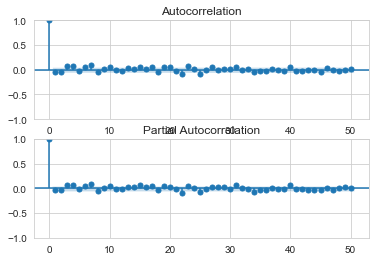

In [8]:
# adfuller test
print("Dickey–Fuller test:: p=%f" % sm.tsa.adfuller(model.resid[13:])[1])

# acf and pacf
res = model.resid
fig, ax = plt.subplots(2, 1)
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

In [9]:
pd.DataFrame(model.resid, columns=['resid']).sort_values(by='resid', ascending=False).head(5)

,resid
2017-12-22,1253.740715
2020-12-29,1077.925512
2017-12-08,1073.776782
2017-12-07,1011.390524
2018-01-17,778.537329


The outlier in date `2017-12-22`?

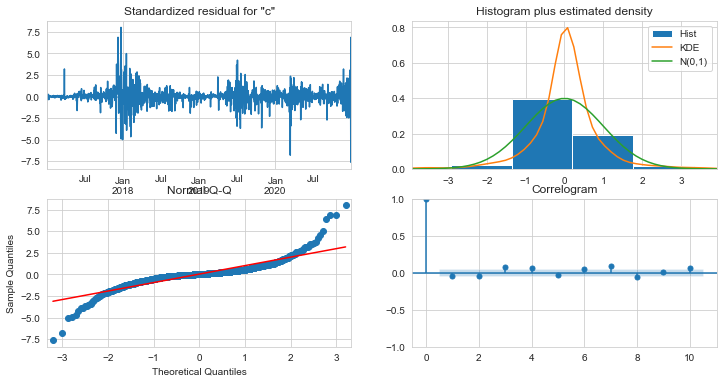

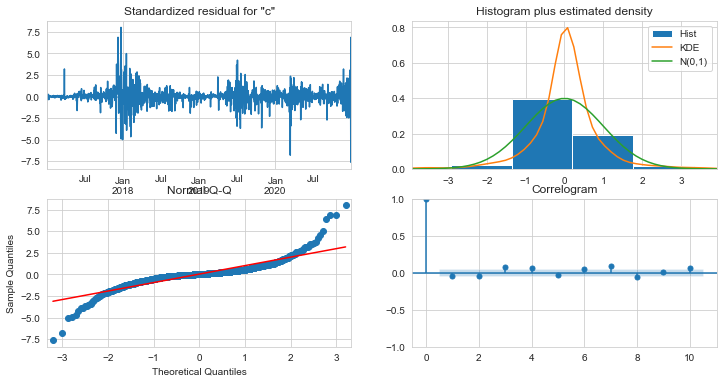

In [10]:
model.plot_diagnostics(figsize=(12, 6))

## Now lets test the model's prediction

In [11]:
# test model
first_predict, last_predict = test.iloc[0].name, test.iloc[-1].name

exog1 = (sm.add_constant(test).loc[first_predict:])
exog1 = exog1.drop(['close'], axis=1)

forecast = model.forecast(steps=len(test), exog=exog1)
result_data = pd.DataFrame(index=test.index, columns=['actual', 'pred'])

# display the forecast accuracy metrics for the test set
print(forecast_accuracy(forecast, test['close'].values))

chk = 0
for i in forecast:
    result_data.iloc[chk]["actual"] = df.iloc[df.index == test.iloc[chk].name]['close'].values[0]
    result_data.iloc[chk]["pred"] = i
    chk += 1
    
result_data.head()

{'mape': '2.12%', 'me': -865.9803092147873, 'mae': 1021.3524550258542, 'mpe': -0.017264564174071604, 'rmse': 1255.5720712064208, 'corr': 0.9963374073147964, 'minmax': 0.021141799797968708}


,actual,pred
2020-12-31,28984.983403,28481.029793
2021-01-01,29405.123461,29223.057507
2021-01-02,32216.53,32125.631259
2021-01-03,33071.5,33887.968626
2021-01-04,32042.188855,29956.996532


We can see the predicted values are quite close to the actual values

In [12]:
# get conf from arima resuls
def forecast_confint(model, exog):
    """
    Returns the confidence interval for the forecast
    """
    conf = model.get_forecast(steps=len(exog), exog=exog)
    return conf.conf_int()


conf = forecast_confint(model, exog1)

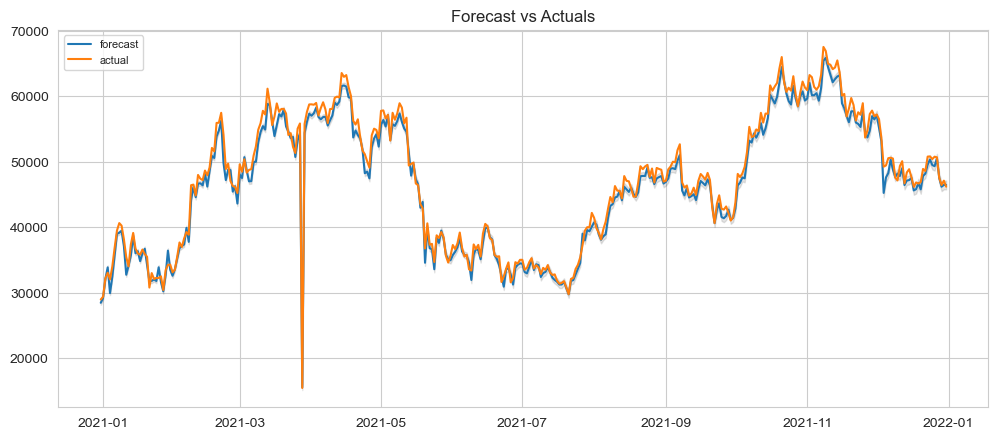

In [13]:
# Make as pandas series
fc_series = pd.Series(forecast, index=test.index)
lower_series = pd.Series(conf.values[:, 0], index=test.index)
upper_series = pd.Series(conf.values[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12, 5), dpi=100)
# plt.plot(train[1500:].close, label='training')
plt.plot(fc_series, label='forecast')
plt.plot(test.close, label='actual')
plt.fill_between(lower_series.index, lower_series,
                 upper_series, color='k', alpha=.1)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


### Forecast Tests
- Make a prediction using the model for the next `n-days/months/years`.
- The `get_new_data()` function gets the BPI from Yahoo Finance for the latest/given dates to compare with the predictions.
- Create a `future` DataFrame with the actual and forecasted values
- Create a mask for a short time frame and visualize it in a plot
- Calculate metrics

In [15]:
from dateutil.relativedelta import relativedelta

# create a list of dates to predict
exog_last = sm.add_constant(df.drop(['close'], axis=1))
start_index = exog_last.index.max().date()
end_index = start_index + relativedelta(days=30)

print("start_index:", start_index)
print("end_index:", end_index)

# predict using the fitted model
yhat5 = model.predict(start=start_index, end=end_index - relativedelta(days=25), exog=exog_last[-371:])
yhat10 = model.predict(start=start_index, end=end_index - relativedelta(days=20), exog=exog_last[-376:])
yhat30 = model.predict(start=start_index, end=end_index, exog=exog_last[-396:])
yhat60 = model.predict(start=start_index, end=end_index + relativedelta(days=30), exog=exog_last[-426:])

# get present values
yhat_actual = get_new_data('BTC-USD', df.index[-1])

start_index: 2021-12-31
end_index: 2022-01-30


RMSE Train: 154.4072854438114
RMSE Test: 1255.5720712064208
RMSE Forecast: 8103.672887056174


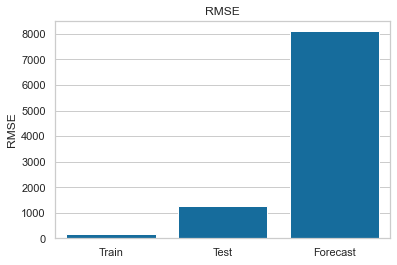

In [16]:
# create histogram of all the rmse from training, test, and forecast
from sklearn.metrics import mean_squared_error
import seaborn as sns
sns.set(style="whitegrid")

rmse_train = np.sqrt(mean_squared_error(train['close'], model.fittedvalues))
rmse_test = np.sqrt(mean_squared_error(result_data['actual'], result_data['pred']))
rmse_forecast = np.sqrt(mean_squared_error(yhat30, yhat_actual[:31].Close.values))

print("RMSE Train:", rmse_train)
print("RMSE Test:", rmse_test)
print("RMSE Forecast:", rmse_forecast)

rmse = pd.DataFrame(index=['Train', 'Test', 'Forecast'], columns=['RMSE'])
rmse.loc['Train'] = rmse_train
rmse.loc['Test'] = rmse_test
rmse.loc['Forecast'] = rmse_forecast

# cat plot for all the rmse
sns.barplot(x=rmse.index, y=rmse.RMSE, color='#0072B2')
plt.title('RMSE')
plt.show()

Make a dataframe with the forecasts for each days and the actual values

In [17]:
def make_future_df(pred, actual):
    future_df = pd.DataFrame(columns=['actual', 'forecast'])
    future_df['forecast'] = pred
    future_df['actual'] = actual
    accuracy = forecast_accuracy(future_df['forecast'], future_df['actual'])

    return future_df, accuracy

future5, acc5 = make_future_df(yhat5, yhat_actual['Close'])
future10, acc10 = make_future_df(yhat10, yhat_actual['Close'])
future30, acc30 = make_future_df(yhat30, yhat_actual['Close'])
future60, acc60 = make_future_df(yhat60, yhat_actual['Close'])

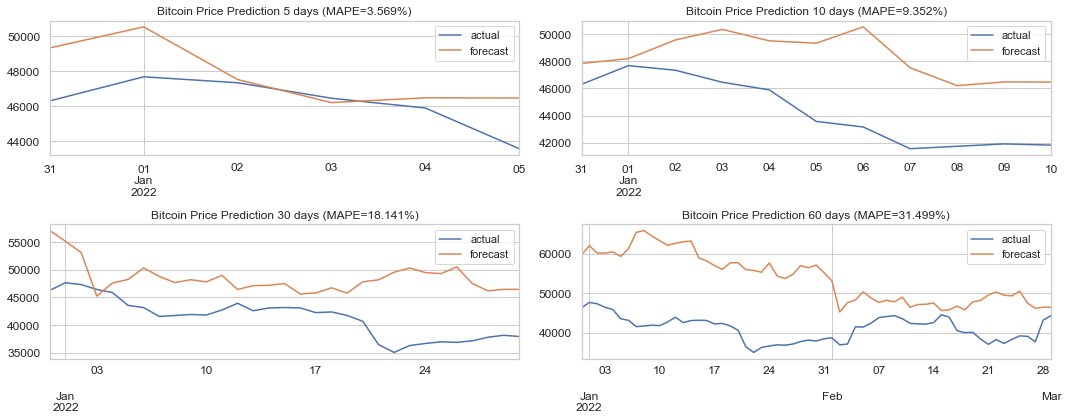

In [18]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2)
fig.figure.set_size_inches(15, 6)

fig = future5.plot(ax=ax1, title=f'Bitcoin Price Prediction 5 days (MAPE={acc5["mape"]})', grid=True, legend=True, fontsize=12)
fig = future10.plot(ax=ax2, title=f'Bitcoin Price Prediction 10 days (MAPE={acc10["mape"]})', grid=True, legend=True, fontsize=12)
fig = future30.plot(ax=ax3, title=f'Bitcoin Price Prediction 30 days (MAPE={acc30["mape"]})', grid=True, legend=True, fontsize=12)
fig = future60.plot(ax=ax4, title=f'Bitcoin Price Prediction 60 days (MAPE={acc60["mape"]})', grid=True, legend=True, fontsize=12)
plt.tight_layout()

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexpected due to the extremely volatile nature of cryptocurrencies, especially in the last 6 months.

It is probably also not such a good idea to try and predict 2 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month or shorter advance predictitons is more sensible. Or maybe even predicting on a daily basis.

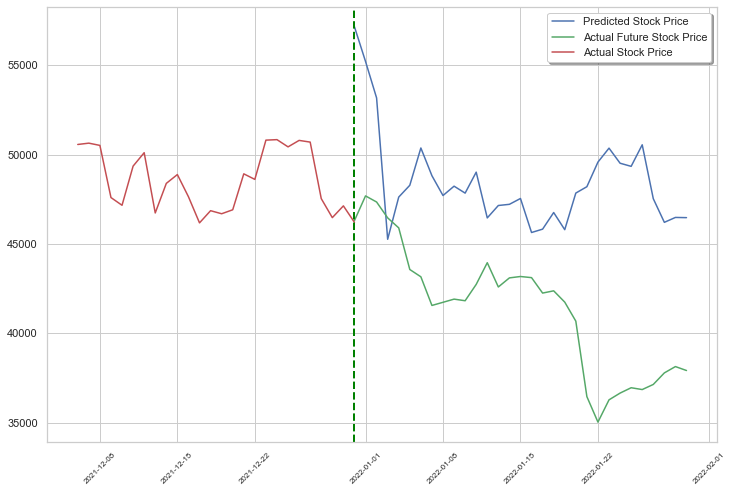

In [22]:
# plot_future(df[1820:].close, future5['forecast'], future5['actual'])
# plot_future(df[1800:].close, future10['forecast'], future10['actual'])
plot_future(df[1800:].close, future30['forecast'], future30['actual'])
# plot_future(df[1700:].close, future60['forecast'], future60['actual'])

At first look, it can be argued that the model simply repeats what it learnt in the dataset
<br>
Since it's pattern is very similar to the testing dataset's values. This may be a case of overfitting.


Create a list of data for each month in the future with the date, actual value, and predicted value, and the past value on this date a year ago.

In [31]:
import plotly.express as px
import plotly.graph_objs as go

cc = []
for i in range(1, 32):
    for j in range(1, 4):
        try:
            d = f'2022-0{j}-{i < 10 and f"0{i}" or i}'
            cc.append({
                'date': d,
                'Forecast_30': future30.iloc[future30.index == d]['forecast'].values[0],
                'Actual': yhat_actual.iloc[yhat_actual.index == d]['Close'].values[0],
                'Past (y-1)': df.iloc[df.index == f'2021-0{j}-{i < 10 and f"0{i}" or i}']['close'].values[0]
            })
        except IndexError as e:
            continue

# merge the list of dictionaries into a dataframe
y_april = pd.DataFrame(
    cc, columns=['date', 'Actual', 'Forecast_30', 'Past (y-1)'])
y_april.set_index('date', inplace=True)
y_april.sort_index(inplace=True)
# y_april.plot(figsize=(10, 5), title='Bitcoin Price Prediction',
#              grid=True, legend=True, fontsize=12)
y_april.head()


,Actual,Forecast_30,Past (y-1)
date,,,
2022-01-01,47686.812500,55209.902395,29405.123461
2022-01-02,47345.218750,53168.171355,32216.530000
2022-01-03,46458.117188,45260.227538,33071.500000
2022-01-04,45897.574219,47620.452642,32042.188855
2022-01-05,43569.003906,48280.617226,34043.030762


In [32]:
fig = px.line(y_april, x=y_april.index, y=y_april.columns[0:3])
fig.show()

In [29]:
fig = px.line(y_april, x=y_april.index, y=y_april.columns[0:2])
fig.show()

This proves that the model was not replicating the patterns it learnt during fitting the model. <br> It has learned the dataset well, however it was unable to capture the trend of the prices.